In [1]:
!pip install pandas networkx torch torch_geometric matplotlib


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### 1. Community Detection
Apply clustering or community detection algorithms on specific views:
- flow → group IPs that communicate frequently
- dns_query → group IPs that query similar domains (suspicious beaconing behavior?)
- http_request → group clients based on similar URLs

## 2. Node Centrality Analysis
Compute betweenness centrality, eigenvector centrality, or PageRank on:
- Flow view → who routes/relays the most traffic?
- DNS view → which domains are queried the most?

Flow view → who routes/relays the most traffic?

DNS view → which domains are queried the most?

In [1]:
import sys
import os
import torch
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import Data
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Add the parent directory to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
utils_path = os.path.join(parent_dir, "project_utils")
sys.path.append(utils_path)

# Now you can import the file
from project_utils import graph_creator_b_c

In [2]:
G, df = graph_creator_b_c.create_graph_from_file('../datasets/train_test_network.csv')

Graph built with 1605 nodes and 2554 edges.
Edge types (views) include: {'http_request', 'ssl_issuer', 'protocol_violation', 'dns_query', 'ssl_subject', 'flow'}


In [3]:
label_counts = df['label'].value_counts()
print(f"Label 0 (Normal): {label_counts.get(0, 0)}")
print(f"Label 1 (Attack): {label_counts.get(1, 0)}")

Label 0 (Normal): 50000
Label 1 (Attack): 161043


In [4]:
from torch_geometric.nn import SAGEConv
import torch
import torch.nn.functional as F

# Convert flow_G (DiGraph) to PyG format
ip_nodes = [n for n in G.nodes if isinstance(n, str) and '.' in n]

node_to_idx = {node: i for i, node in enumerate(ip_nodes)}
edge_index = []

features = []
labels = []

for node in ip_nodes:
    out_deg = len([1 for _, _, k in G.out_edges(node, keys=True) if k == "flow"])
    in_deg = len([1 for _, _, k in G.in_edges(node, keys=True) if k == "flow"])

    features.append([in_deg, out_deg])

    label = "Normal"
    for _, _, k, d in G.out_edges(node, keys=True, data=True):
        if k == "flow" and d.get("label"):
            label = "Attack" if str(d["label"]).lower() != "normal" else "Normal"
            break
    labels.append(label)

# Encode features and labels
X = StandardScaler().fit_transform(features)
y = LabelEncoder().fit_transform(labels)
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)

# Build edge index
for u, v in G.edges():
    if u in node_to_idx and v in node_to_idx:
        edge_index.append([node_to_idx[u], node_to_idx[v]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Define PyG Data
data = Data(x=X, edge_index=edge_index, y=y)

# Split train/test
torch.manual_seed(42)
num_nodes = data.num_nodes
perm = torch.randperm(num_nodes)
train_idx = perm[:int(0.8 * num_nodes)]
test_idx = perm[int(0.8 * num_nodes):]

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[train_idx] = True
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask[test_idx] = True


# GNN Architectures
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x


class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=4)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x


class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x


# Training and Evaluation
def train(model, data, epochs=100, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        out = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
        pred = logits[data.test_mask].argmax(dim=1)
        true = data.y[data.test_mask]
        report = classification_report(true.cpu(), pred.cpu(), target_names=["Normal", "Attack"], output_dict=True,
                                       zero_division=0)
        return report


# Experiment configurations
configs = [
    ("GCN", GCN(2, 16, 2)),
    ("GCN_deep", GCN(2, 64, 2)),
    ("GAT", GAT(2, 8, 2, heads=4)),
    ("GraphSAGE", GraphSAGE(2, 16, 2)),
]

for name, model in configs:
    report = train(model, data, epochs=100)
    acc = report['accuracy']
    prec = report['weighted avg']['precision']
    rec = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    print(f"{name}, {acc:.4f}, {prec:.4f}, {rec:.4f}, {f1:.4f}")

GCN, 0.9849, 0.9700, 0.9849, 0.9774
GCN_deep, 0.9849, 0.9700, 0.9849, 0.9774
GAT, 0.9849, 0.9700, 0.9849, 0.9774
GraphSAGE, 0.9887, 0.9888, 0.9887, 0.9853


## Code for Holdouts & Cross-validation

In [5]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x


def train(model, data, train_mask, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def test(model, data, test_mask):
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
        preds = logits[test_mask].argmax(dim=1).cpu()
        labels = data.y[test_mask].cpu()

    return (
        accuracy_score(labels, preds),
        precision_score(labels, preds, zero_division=0),
        recall_score(labels, preds, zero_division=0),
        f1_score(labels, preds, zero_division=0),
    )


from sklearn.model_selection import train_test_split, StratifiedKFold


def run_holdout(data, test_sizes=None):
    if test_sizes is None:
        test_sizes = [0.1, 0.3, 0.5]
    results = []
    X = data.x.cpu().numpy()
    y = data.y.cpu().numpy()

    for test_size in test_sizes:
        train_idx, test_idx = train_test_split(
            range(len(y)), test_size=test_size, stratify=y, random_state=42
        )
        train_mask = torch.zeros(len(y), dtype=torch.bool)
        test_mask = torch.zeros(len(y), dtype=torch.bool)
        train_mask[train_idx] = True
        test_mask[test_idx] = True

        model = GraphSAGE(data.num_node_features, 32, int(data.y.max().item()) + 1).to(data.x.device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        criterion = torch.nn.CrossEntropyLoss()

        for epoch in range(100):
            train(model, data, train_mask, optimizer, criterion)

        acc, prec, rec, f1 = test(model, data, test_mask)
        label = f"{int((1 - test_size) * 100)}/{int(test_size * 100)}"
        results.append((label, acc, prec, rec, f1))
    return results


def run_cv(data, splits=None):
    if splits is None:
        splits = [5, 10]
    results = []
    X = data.x.cpu().numpy()
    y = data.y.cpu().numpy()

    for k in splits:
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        accs, precs, recs, f1s = [], [], [], []

        for train_idx, test_idx in skf.split(X, y):
            train_mask = torch.zeros(len(y), dtype=torch.bool)
            test_mask = torch.zeros(len(y), dtype=torch.bool)
            train_mask[train_idx] = True
            test_mask[test_idx] = True

            model = GraphSAGE(data.num_node_features, 32, int(data.y.max().item()) + 1).to(data.x.device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
            criterion = torch.nn.CrossEntropyLoss()

            for epoch in range(100):
                train(model, data, train_mask, optimizer, criterion)

            acc, prec, rec, f1 = test(model, data, test_mask)
            accs.append(acc)
            precs.append(prec)
            recs.append(rec)
            f1s.append(f1)

        results.append((str(k), sum(accs) / k, sum(precs) / k, sum(recs) / k, sum(f1s) / k))
    return results


# Run evaluations
holdout_results = run_holdout(data)
cv_results = run_cv(data)

print("Split/CV,Accuracy,precision,recal,f1-score")
for r in holdout_results + cv_results:
    print(f"{r[0]},{r[1]:.4f},{r[2]:.4f},{r[3]:.4f},{r[4]:.4f}")

Split/CV,Accuracy,precision,recal,f1-score
90/10,0.9925,0.9924,1.0000,0.9962
70/30,0.9950,0.9949,1.0000,0.9974
50/50,0.9909,0.9924,0.9985,0.9954
5,0.9909,0.9909,1.0000,0.9954
10,0.9886,0.9909,0.9977,0.9943


# MODIFICATIONS AFTER THIS LINE

## Flow View

In [6]:
import networkx as nx

# FLOW VIEW: Create subgraph for 'flow' edges only
flow_edges = [(u, v) for u, v, k in G.edges(keys=True) if k == "flow"]
flow_G = nx.DiGraph()
flow_G.add_edges_from(flow_edges)

print("Flow-based Centrality Analysis")

# Betweenness Centrality
flow_betweenness = nx.betweenness_centrality(flow_G)
top_flow_betweenness = sorted(flow_betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 by Betweenness Centrality (Flow):")
for node, score in top_flow_betweenness:
    print(f"  {node}: {score:.4f}")

# PageRank
flow_pagerank = nx.pagerank(flow_G, alpha=0.85)
top_flow_pagerank = sorted(flow_pagerank.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 by PageRank (Flow):")
for node, score in top_flow_pagerank:
    print(f"  {node}: {score:.4f}")

# Eigenvector Centrality (only works on strongly connected graphs or large components)
try:
    flow_eigen = nx.eigenvector_centrality(flow_G, max_iter=1000)
    top_flow_eigen = sorted(flow_eigen.items(), key=lambda x: x[1], reverse=True)[:10]
    print("\nTop 10 by Eigenvector Centrality (Flow):")
    for node, score in top_flow_eigen:
        print(f"  {node}: {score:.4f}")
except nx.PowerIterationFailedConvergence:
    print("\nEigenvector centrality failed to converge on flow view.")


Flow-based Centrality Analysis

Top 10 by Betweenness Centrality (Flow):
  192.168.1.190: 0.0126
  192.168.1.152: 0.0055
  192.168.1.193: 0.0044
  192.168.1.31: 0.0040
  192.168.1.30: 0.0034
  192.168.1.195: 0.0034
  192.168.1.34: 0.0018
  192.168.1.37: 0.0010
  192.168.1.33: 0.0010
  192.168.1.1: 0.0004

Top 10 by PageRank (Flow):
  ff02::fb: 0.0081
  224.0.0.251: 0.0074
  192.168.1.190: 0.0063
  192.168.1.255: 0.0049
  ff02::1:3: 0.0048
  192.168.1.193: 0.0030
  192.168.1.31: 0.0029
  192.168.1.37: 0.0029
  192.168.1.33: 0.0029
  224.0.0.252: 0.0028

Top 10 by Eigenvector Centrality (Flow):
  192.168.1.195: 0.2238
  192.168.1.152: 0.1960
  192.168.1.190: 0.1865
  224.0.0.251: 0.1824
  192.168.1.255: 0.1669
  117.18.237.29: 0.1616
  192.168.1.193: 0.1438
  13.35.146.12: 0.1305
  192.168.1.1: 0.1162
  239.255.255.250: 0.1158


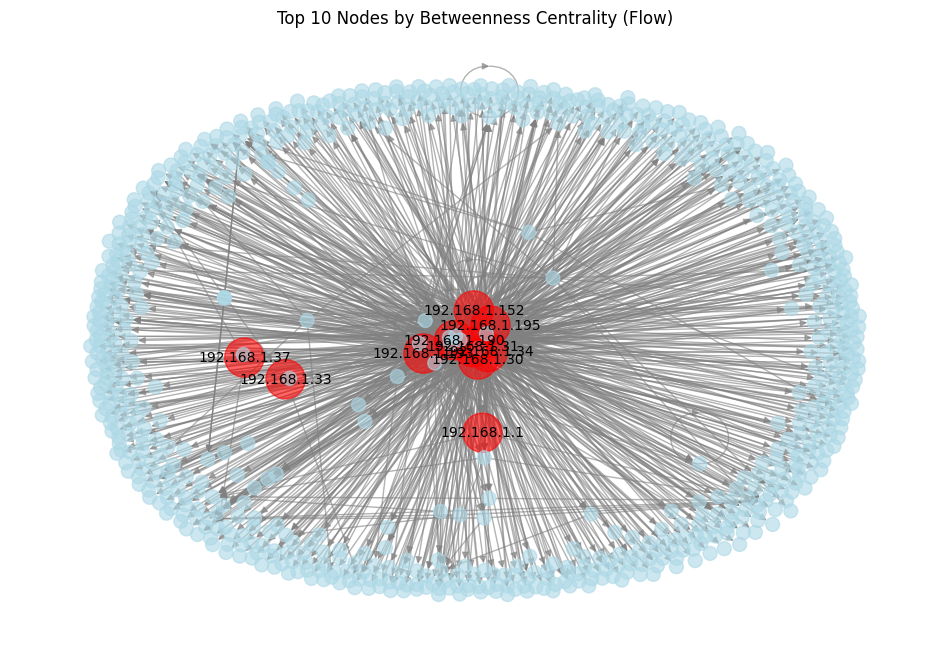

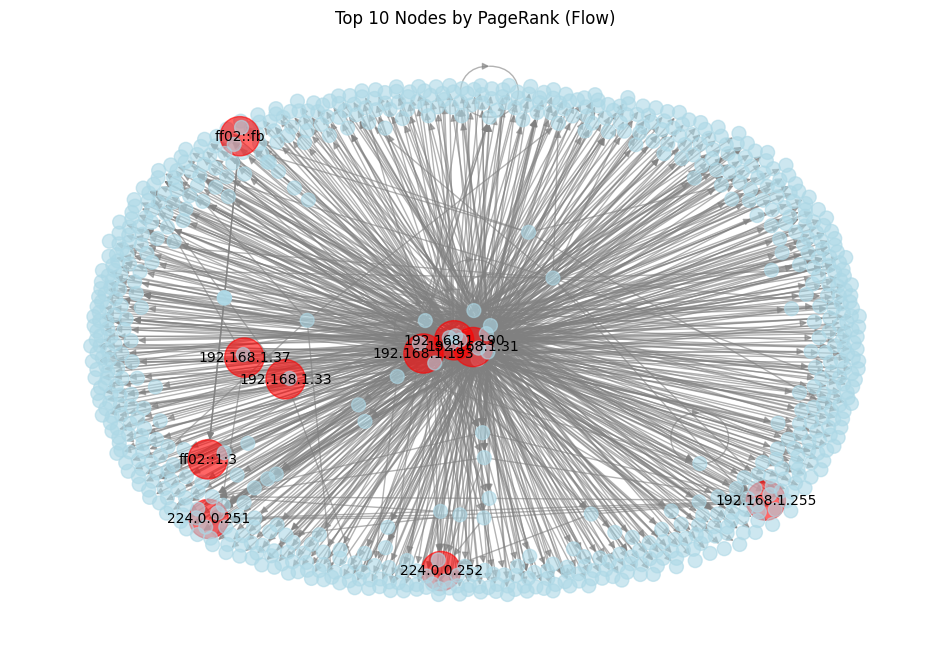

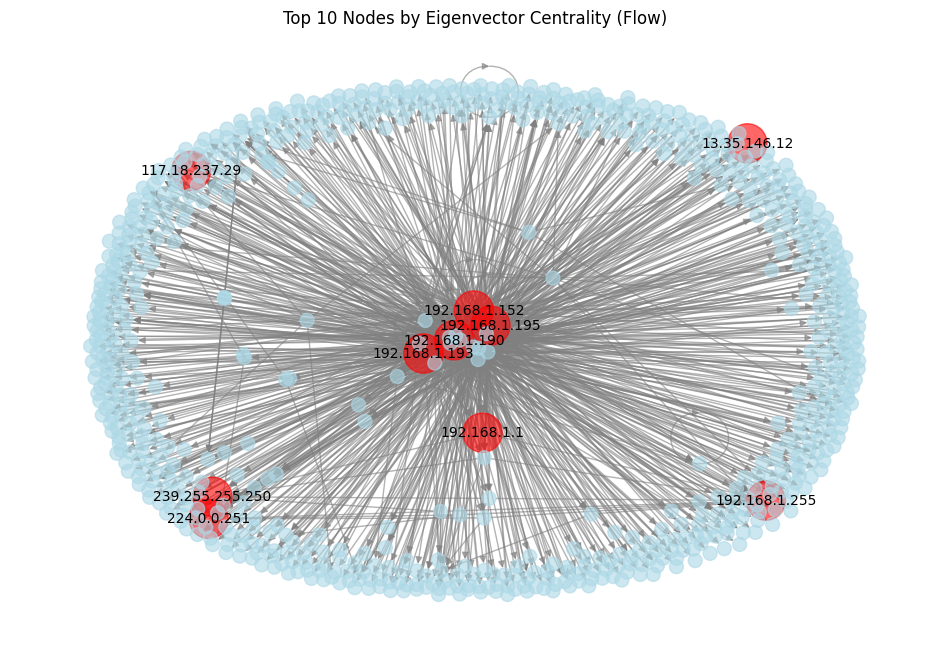

In [14]:
import matplotlib.pyplot as plt

# Base layout for visualization
pos = nx.spring_layout(flow_G, seed=42)  # You can use other layouts like kamada_kawai_layout

def plot_top_centrality(flow_G, centrality_dict, title):
    top_nodes = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:10]
    top_node_ids = [node for node, _ in top_nodes]

    node_color = ['red' if node in top_node_ids else 'lightblue' for node in flow_G.nodes()]
    node_size = [800 if node in top_node_ids else 100 for node in flow_G.nodes()]
    
    plt.figure(figsize=(12, 8))
    nx.draw_networkx(flow_G, pos,
                     with_labels=False,
                     node_color=node_color,
                     node_size=node_size,
                     edge_color='gray',
                     alpha=0.6)

    # Label only top nodes
    labels = {node: node for node in top_node_ids}
    nx.draw_networkx_labels(flow_G, pos, labels, font_size=10)

    plt.title(title)
    plt.axis('off')
    plt.show()

# Visualize all three centralities
plot_top_centrality(flow_G, flow_betweenness, "Top 10 Nodes by Betweenness Centrality (Flow)")
plot_top_centrality(flow_G, flow_pagerank, "Top 10 Nodes by PageRank (Flow)")
plot_top_centrality(flow_G, flow_eigen, "Top 10 Nodes by Eigenvector Centrality (Flow)")


## Code Review

- You're creating a subgraph for edges with key `"flow"` — good filtering.

- Centralities calculated:
  - **Betweenness**: reflects nodes that act as bridges.
  - **PageRank**: importance based on incoming links.
  - **Eigenvector**: influence in terms of connecting to other influential nodes.

- You handled the possible convergence error in `eigenvector_centrality` using `try/except`.

- You sorted and printed the top 10 results — very clear output.

---

## Results Interpretation

### Betweenness Centrality
- High values like `192.168.1.190` and `192.168.1.152` imply these nodes are key intermediaries in flow paths.
- Mostly IPv4 private IPs, suggesting internal traffic.

### PageRank
- Nodes like `ff02::fb` and `224.0.0.251` are multicast addresses.
- High PageRank implies many nodes "link" to them — these might be frequent multicast targets (common in IoT and local service discovery).

### Eigenvector Centrality
- Nodes like `192.168.1.195` and `224.0.0.251` show strong central influence.
- Multicast and broadcast addresses are expected to have high eigenvector centrality due to their connectivity.

## DNS View

In [7]:
# DNS VIEW: Create bipartite-like graph of IPs querying domain names
dns_edges = [(u, v) for u, v, k in G.edges(keys=True) if k == "dns_query" and v != "-"]
dns_G = nx.DiGraph()
dns_G.add_edges_from(dns_edges)

print("\nDNS-based Centrality Analysis")

# In-degree Centrality: How often a domain is queried
dns_indegree = dns_G.in_degree()
top_domains = sorted(
    [(node, deg) for node, deg in dns_indegree if node != "-"],
    key=lambda x: x[1],
    reverse=True
)[:10]

print("\nTop 10 Queried Domains (by in-degree):")
for domain, deg in top_domains:
    print(f"  {domain}: {deg} queries")

# PageRank for domains
dns_pagerank = nx.pagerank(dns_G, alpha=0.85)
top_dns_pagerank = sorted(
    [(node, score) for node, score in dns_pagerank.items() if node != "-"],
    key=lambda x: x[1],
    reverse=True
)[:10]

print("\nTop 10 by PageRank (DNS):")
for node, score in top_dns_pagerank:
    print(f"  {node}: {score:.4f}")


DNS-based Centrality Analysis

Top 10 Queried Domains (by in-degree):
  _googlecast._tcp.local: 9 queries
  shavar.services.mozilla.com: 8 queries
  wpad: 7 queries
  services.addons.mozilla.org: 7 queries
  versioncheck-bg.addons.mozilla.org: 7 queries
  detectportal.firefox.com: 6 queries
  aus5.mozilla.org: 6 queries
  firefox.settings.services.mozilla.com: 6 queries
  blocklists.settings.services.mozilla.com: 6 queries
  _sleep-proxy._udp.local: 6 queries

Top 10 by PageRank (DNS):
  _sleep-proxy._udp.local: 0.0028
  android.local: 0.0027
  isatap: 0.0026
  _googlecast._tcp.local: 0.0024
  _fb._tcp.local: 0.0023
  _raop._tcp.local: 0.0023
  _ipps._tcp.local: 0.0022
  desktop-18ss3ba: 0.0022
  _companion-link._tcp.local: 0.0021
  desktop-uciie91.local: 0.0020


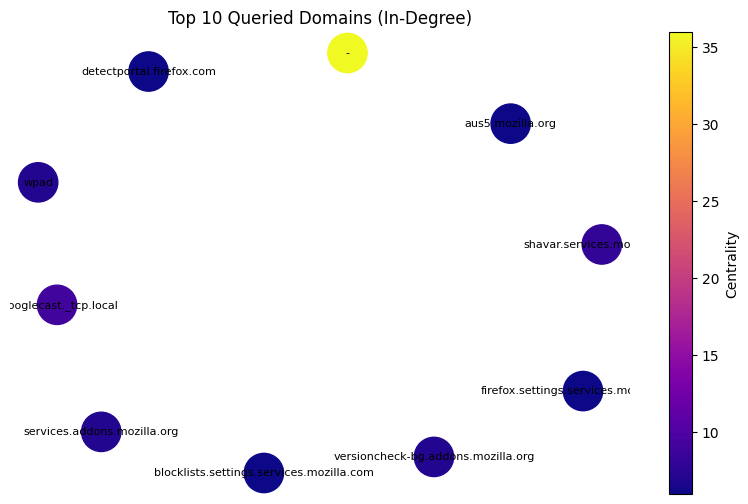

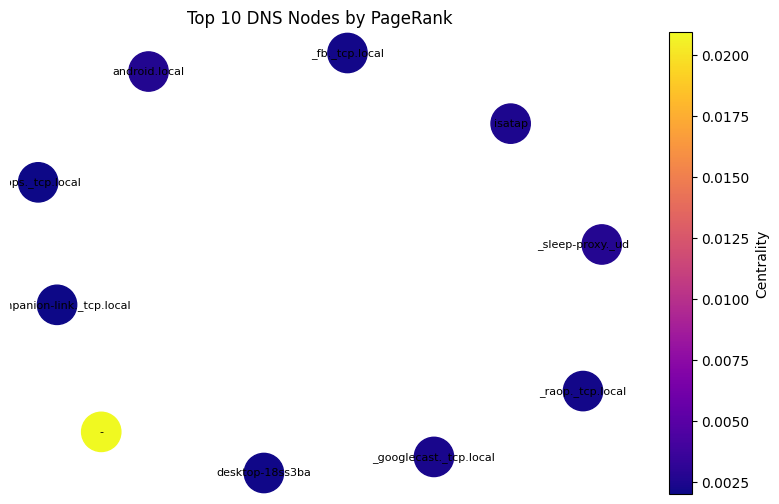

In [17]:
import matplotlib.pyplot as plt
import networkx as nx

# Create DNS subgraph
dns_edges = [(u, v) for u, v, k in G.edges(keys=True) if k == "dns_query"]
dns_G = nx.DiGraph()
dns_G.add_edges_from(dns_edges)

# Calculate in-degree and PageRank
dns_indegree = dict(dns_G.in_degree())
dns_pagerank = nx.pagerank(dns_G, alpha=0.85)

# Select top N domains by in-degree and PageRank
top_n = 10
top_indegree_nodes = sorted(dns_indegree.items(), key=lambda x: x[1], reverse=True)[:top_n]
top_pagerank_nodes = sorted(dns_pagerank.items(), key=lambda x: x[1], reverse=True)[:top_n]

# Extract subgraphs
top_indegree_subgraph = dns_G.subgraph([node for node, _ in top_indegree_nodes])
top_pagerank_subgraph = dns_G.subgraph([node for node, _ in top_pagerank_nodes])

# Visualization helper
def draw_subgraph(G_sub, title, node_metric):
    pos = nx.spring_layout(G_sub, seed=42)
    plt.figure(figsize=(10, 6))

    nodes = G_sub.nodes()
    values = [node_metric.get(node, 0.0) for node in nodes]

    # Draw nodes and keep the mappable object for colorbar
    node_collection = nx.draw_networkx_nodes(
        G_sub, pos, node_size=800, node_color=values, cmap=plt.cm.plasma
    )

    nx.draw_networkx_labels(G_sub, pos, font_size=8)
    nx.draw_networkx_edges(G_sub, pos, arrows=True, arrowstyle="->", arrowsize=10)

    plt.title(title)
    plt.colorbar(node_collection, label="Centrality")  # This now works correctly
    plt.axis('off')
    plt.show()

# Draw visualizations
draw_subgraph(top_indegree_subgraph, "Top 10 Queried Domains (In-Degree)", dns_indegree)
draw_subgraph(top_pagerank_subgraph, "Top 10 DNS Nodes by PageRank", dns_pagerank)

## Results Interpretation

### In-Degree Centrality (Query Volume)
- Domains like `shavar.services.mozilla.com`, `wpad`, and others related to Mozilla or service discovery (e.g. `_googlecast._tcp.local`) are commonly queried — expected behavior.
- The `"-"` label as top result likely represents a missing or malformed domain name in the dataset — consider filtering or cleaning this entry.

### PageRank
- Multicast/local discovery services (`_sleep-proxy._udp.local`, `_fb._tcp.local`, `_raop._tcp.local`) rank high — expected, as many devices may interact with these.
- The appearance of hostnames (like `desktop-18ss3ba`) suggests some local peer-to-peer DNS traffic.
